## Feature Estimation & PCA Analysis 
- This notebook is used to estimate the features of the neurons and perform PCA analysis. 
- Place Field Features: 
    - Peak Rate 
    - Average Rate
    - Place Field Width
    - Place Field Peak Location
    - Number of Place Fields
    - Percentage of Trials Close to Peak
    - Presence Ratio
- PCA Analysis: 
    - Perform PCA on the features
    - Plot the explained variance
    - Plot the PCA scores
    - Plot the PCA loadings






In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from convnwb.io import get_files, load_jsons_to_df
from scipy.stats import binom_test
from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [2]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [3]:
import sys
sys.path.append('../code')
from utils import find_place_field,find_place_location

sys.path.append('../scripts')
from settings import PATHS, METHODS

In [4]:
results_folder = PATHS['RESULTS'] / 'units'
reports_folder = PATHS['REPORTS'] / 'units'


In [5]:
locations_folder = PATHS['BASE'] / 'localization'/'Loc'
locations_files = get_files(locations_folder, select='session_data')
Locations = load_jsons_to_df(locations_files, folder=locations_folder)


In [6]:
# Get the list of files
res_files = get_files(results_folder, select='mat')

In [7]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=results_folder)

In [8]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))
# Collect numbers of significant cells
analyses = create_methods_list(METHODS)
# Statistics settings
alpha_level = 0.05
binom_sidedness = 'greater'   
results = {}
for analysis in analyses:
    all_results[f'is_{analysis}'] = (all_results[f'{analysis}_surr_p_val'] < alpha_level).values

for analysis in analyses:
     results[analysis] = sum(all_results['is_' + analysis])


# Compute significance of the counts of detected neurons
all_stats = {}
for analysis in analyses:
    all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)

Total number of cells: 390


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_19305/3223072776.py:20: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)


In [9]:
# Check the number & percent of significant cells per analysis
print('total cells: {}\n'.format( n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, all_stats[analysis]))

total cells: 390

# place_anova cells:     		 85  (21.79%) 		 0.0000
# place_info cells:     		 84  (21.54%) 		 0.0000
# place_fr_anova cells:     		 54  (13.85%) 		 0.0000
# place_fr_info cells:     		 63  (16.15%) 		 0.0000


In [10]:
spike_names = all_results['spike_name']
labels = all_results['label']

In [11]:
all_results['channel'] = spike_names.str.extract(r'(?:NSX|CSC)(\d+)')[0].str.lstrip('0')
all_results['sessions'] = all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[0] + '_' + all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[1]


## Get Features 

In [12]:
## Compute Features
# Initialize new columns with appropriate data types
all_results['peak_rate'] = np.nan
all_results['average_rate'] = np.nan
all_results['SNR'] = np.nan
all_results['place_field_bins'] = pd.Series([None] * len(all_results))
all_results['noise_bins'] = pd.Series([None] * len(all_results))
all_results['labeled_fields'] = pd.Series([None] * len(all_results))
all_results['N_place_fields'] = pd.Series([None] * len(all_results))
all_results['place_field_peak_location'] = pd.Series([None] * len(all_results))
all_results['trial_peak_loc'] = pd.Series([None] * len(all_results))
all_results['trial_peak_rate'] = pd.Series([None] * len(all_results))
all_results['num_trials_close_to_peak'] = pd.Series([None] * len(all_results))
all_results['percentage_num_trials_close_to_peak'] = pd.Series([None] * len(all_results))

# Calculate basic rate features
all_results['peak_rate'] = all_results['place_bins'].apply(np.max)
all_results['average_rate'] = all_results['place_bins'].apply(np.mean)
all_results['SNR'] = all_results['peak_rate'] / all_results['average_rate']

# Calculate place field features for each unit
for i in range(len(all_results)):
    # Forward direction analysis
    (all_results.at[i,'place_field_bins'], 
     all_results.at[i,'noise_bins'],
     all_results.at[i,'labeled_fields'], 
     all_results.at[i,'N_place_fields'],
     all_results.at[i,'peak_rate'],
     all_results.at[i,'place_field_peak_location']) = find_place_field(all_results['place_bins'][i])

    (all_results.at[i,'trial_peak_loc'],
     all_results.at[i,'trial_peak_rate'], 
     all_results.at[i,'num_trials_close_to_peak'],
     all_results.at[i,'percentage_num_trials_close_to_peak']) = find_place_location(all_results['trial_place_bins'][i], 
                                                                                   all_results['place_field_peak_location'][i],tolerance = 6)



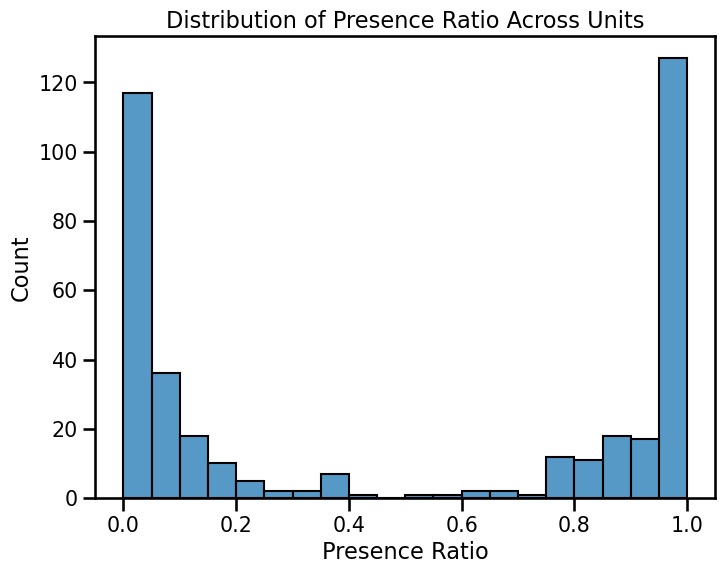

In [13]:
all_results['presence_ratio'] = all_results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))

# Plot distribution of presence ratio
plt.figure(figsize=(8, 6))
sns.histplot(data=all_results, x='percentage_num_trials_close_to_peak', bins=20)
plt.xlabel('Presence Ratio')
plt.ylabel('Count')
plt.title('Distribution of Presence Ratio Across Units')
plt.show()

## PCA Analysis 

In [14]:
### Feature selection
features = [
    'place_field_bins',
    'N_place_fields',
    'peak_rate',
    'percentage_num_trials_close_to_peak', 
    'SNR',
    'average_rate',
    'presence_ratio'
]

In [15]:
# Drop NaN values and scale the feature data
mask = all_results[features].notna().all(axis=1)
data_no_nan = all_results[features][mask]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_no_nan)

# Performing PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Create DataFrame with PCA results and metadata
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['unit_ind'] = data_no_nan.index.map(all_results['unit_ind'])
pca_df['session_id'] = data_no_nan.index.map(all_results['session_id'])

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Get the feature importance for first two components
components = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)
print("\nFeature importance for first two principal components:")
print(components[['PC1', 'PC2']].round(3))







Feature importance for first two principal components:
                                       PC1    PC2
place_field_bins                     0.438 -0.412
N_place_fields                      -0.356 -0.104
peak_rate                            0.432  0.465
percentage_num_trials_close_to_peak -0.153  0.474
SNR                                 -0.295  0.513
average_rate                         0.474  0.340
presence_ratio                       0.399  0.013


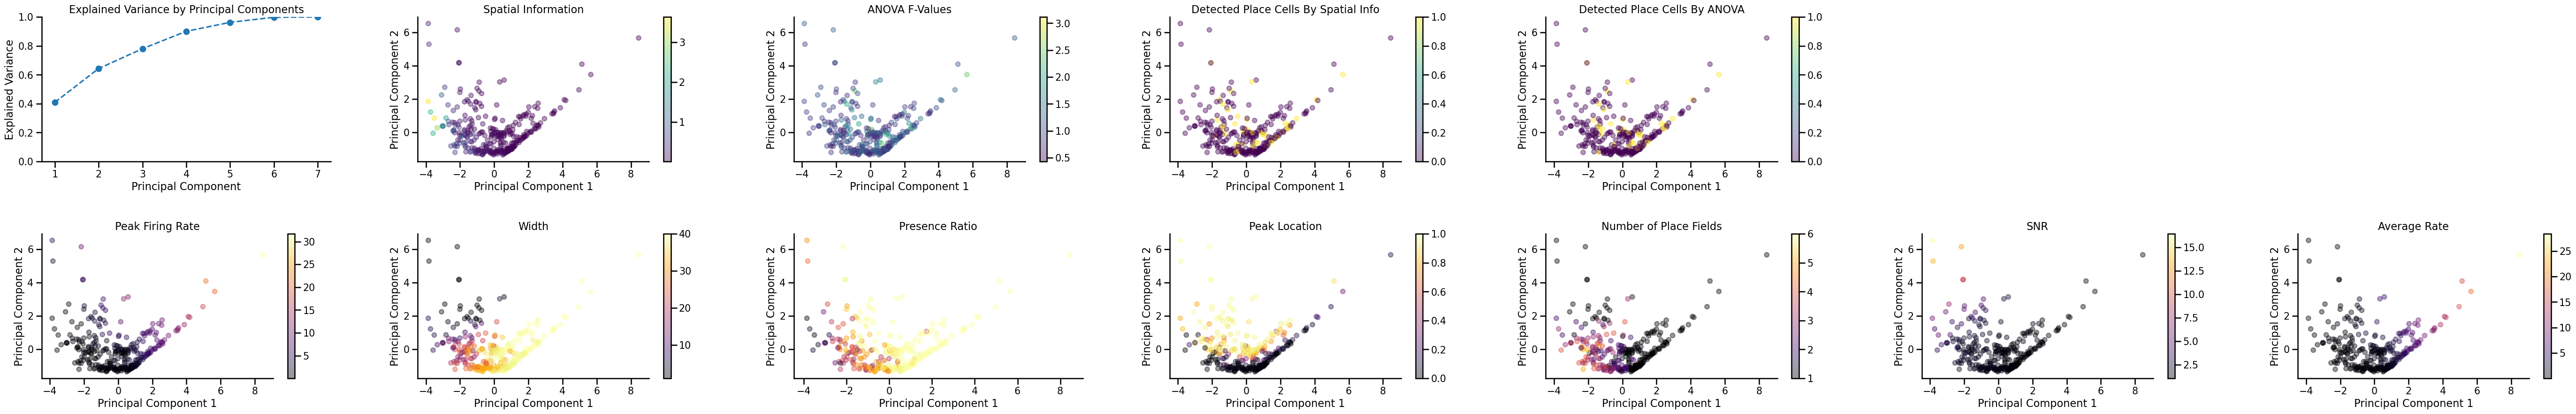

In [16]:
# Plotting the explained variance
grid = make_grid(2, 7, wspace=.3, hspace=.5, figsize=(70, 10),
                 width_ratios=[1,1,1,1,1,1,1])

ax = get_grid_subplot(grid, 0, 0)
ax.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
ax.set_ylim(0,1)
ax.set_title('Explained Variance by Principal Components')  
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
drop_spines(['top','right'], ax=ax)

ax = get_grid_subplot(grid, 0, 1)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['place_fr_info'], s=50, alpha=0.4, cmap='viridis',
    vmin=all_results[mask]['place_fr_info'].min(), vmax=all_results[mask]['place_fr_info'].max()
)
plt.colorbar(scatter, ax=ax)
ax.set_title('Spatial Information')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 0, 2)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['place_fr_anova'], s=50, alpha=0.4, cmap='viridis',
    vmin=all_results[mask]['place_fr_anova'].min(), vmax=all_results[mask]['place_fr_anova'].max()
)
plt.colorbar(scatter, ax=ax)
ax.set_title('ANOVA F-Values')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 0, 3)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['is_place_fr_info'], s=50, alpha=0.4, cmap='viridis',
    vmin=0, vmax=1)  # Binary values, keep 0-1
plt.colorbar(scatter, ax=ax)
ax.set_title('Detected Place Cells By Spatial Info')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 0, 4)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['is_place_fr_anova'], s=50, alpha=0.4, cmap='viridis',
    vmin=0, vmax=1)  # Binary values, keep 0-1
plt.colorbar(scatter, ax=ax)
ax.set_title('Detected Place Cells By ANOVA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 1, 0)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['peak_rate'], s=50, alpha=0.4, cmap='inferno',
    vmin=all_results[mask]['peak_rate'].min(), vmax=all_results[mask]['peak_rate'].max()
)
plt.colorbar(scatter, ax=ax)
ax.set_title('Peak Firing Rate')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 1, 1)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['place_field_bins'], s=50, alpha=0.4, cmap='inferno',
    vmin=all_results[mask]['place_field_bins'].min(), vmax=all_results[mask]['place_field_bins'].max()
)
plt.colorbar(scatter, ax=ax)
ax.set_title('Width')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 1, 2)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['presence_ratio'], s=50, alpha=0.4, cmap='inferno',
    vmin=all_results[mask]['presence_ratio'].min(), vmax=all_results[mask]['presence_ratio'].max()
)
ax.set_title('Presence Ratio')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)


ax = get_grid_subplot(grid, 1, 3)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['percentage_num_trials_close_to_peak'], s=50, alpha=0.4, cmap='inferno',
    vmin=all_results[mask]['percentage_num_trials_close_to_peak'].min(),
    vmax=all_results[mask]['percentage_num_trials_close_to_peak'].max()
)
plt.colorbar(scatter, ax=ax)
ax.set_title('Peak Location')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 1, 4)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['N_place_fields'], s=50, alpha=0.4, cmap='inferno',
    vmin=all_results[mask]['N_place_fields'].min(), vmax=all_results[mask]['N_place_fields'].max()
)
plt.colorbar(scatter, ax=ax)
ax.set_title('Number of Place Fields')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 1, 5)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['SNR'], s=50, alpha=0.4, cmap='inferno',
    vmin=all_results[mask]['SNR'].min(), vmax=all_results[mask]['SNR'].max())
plt.colorbar(scatter, ax=ax)
ax.set_title('SNR')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 1, 6)
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['average_rate'], s=50, alpha=0.4, cmap='inferno',
    vmin=all_results[mask]['average_rate'].min(), vmax=all_results[mask]['average_rate'].max())
plt.colorbar(scatter, ax=ax)
ax.set_title('Average Rate')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
drop_spines(['top', 'right'], ax=ax)


In [17]:

s_bins = np.linspace(0, 40, len(all_results['place_bins'][0]))

In [7]:
# Plotting the explained variance
pad = 20
grid = make_grid(2, 6, wspace=.5, hspace=.5, figsize=(35, 11))
plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 30,
    'axes.labelsize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 30
})

# Main scatter plots side by side
ax_scatter_si = get_grid_subplot(grid, slice(0,1), slice(1,3))
scatter_si = ax_scatter_si.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['place_info'], s=100, alpha=.6, cmap='Reds', vmin=-.2, vmax=1
)
plt.colorbar(scatter_si, ax=ax_scatter_si, label='SI (bits/spike)')
#ax_scatter_si.set_title('Spatial Information', pad=15)
ax_scatter_si.set_xlabel('PC 1')
ax_scatter_si.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax_scatter_si)

ax_scatter_anova = get_grid_subplot(grid, slice(0,1), slice(3,5))
scatter_anova = ax_scatter_anova.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['place_anova'], s=100, alpha=.6, cmap='Blues', vmin=-.2, vmax=3
)
plt.colorbar(scatter_anova, ax=ax_scatter_anova, label='F-Statistic')
ax_scatter_anova.set_xlabel('PC 1')
ax_scatter_anova.set_ylabel('PC 2')
#ax_scatter_anova.set_title('ANOVA', pad=15)
drop_spines(['top', 'right'], ax=ax_scatter_anova)

si_stats = all_results[mask]['place_info']
si_min = si_stats.min()
si_max = si_stats.max()
si_median = si_stats.median()

f_stats = all_results[mask]['place_anova']
f_min = f_stats.min()
f_max = f_stats.max()
f_median = f_stats.median()

# Plot min/max points and their firing rate plots
si_max_idx = np.abs(all_results[mask]['place_info'] - si_max).argmin()
si_min_idx = np.abs(all_results[mask]['place_info'] - si_min).argmin()
si_median_idx = np.abs(all_results[mask]['place_info'] - si_median).argmin()
f_max_idx = np.abs(all_results[mask]['place_anova'] - f_max).argmin()
f_min_idx = np.abs(all_results[mask]['place_anova'] - f_min).argmin()
f_median_idx = np.abs(all_results[mask]['place_anova'] - f_median).argmin()

# Plot min/max points on scatter plots with annotations
# SI scatter annotations
# ax_scatter_si.scatter(
#     pca_result[si_max_idx, 0],
#     pca_result[si_max_idx, 1],
#     c='darkred', s=700, alpha=1, marker='*', label='Maximum SI'
# )
# ax_scatter_si.scatter(
#     pca_result[si_min_idx, 0],
#     pca_result[si_min_idx, 1],
#     c='lightcoral', s=700, alpha=1, marker='*', label='Minimum SI'
# )
# ax_scatter_si.scatter(
#     pca_result[si_median_idx, 0],
#     pca_result[si_median_idx, 1],
#     c='grey', s=700, alpha=1, marker='*', label='Median SI'
# )
# # ax_scatter_si.annotate(f'Max SI: {si_max:.2f}', 
# #     xy=(pca_result[si_max_idx, 0], pca_result[si_max_idx, 1]),
# #     xytext=(10, 10), textcoords='offset points')
# # ax_scatter_si.annotate(f'Min SI: {si_min:.2f}',
# #     xy=(pca_result[si_min_idx, 0], pca_result[si_min_idx, 1]),
# #     xytext=(10, 10), textcoords='offset points')
# # ax_scatter_si.annotate(f'Median SI: {si_median:.2f}',
# #     xy=(pca_result[si_median_idx, 0], pca_result[si_median_idx, 1]),
# #     xytext=(10, 10), textcoords='offset points')


# # ANOVA scatter annotations
# ax_scatter_anova.scatter(
#     pca_result[f_max_idx, 0],
#     pca_result[f_max_idx, 1],
#     c='darkblue', s=700, alpha=1, marker='*', label='Maximum F'
# )
# ax_scatter_anova.scatter(
#     pca_result[f_min_idx, 0],
#     pca_result[f_min_idx, 1],
#     c='blue', s=700, alpha=1, marker='*', label='Minimum F'
# )
# ax_scatter_anova.scatter(
#     pca_result[f_median_idx, 0],
#     pca_result[f_median_idx, 1],
#     c='grey', s=700, alpha=1, marker='*', label='Median F'
# )
# ax_scatter_anova.annotate(f'Max F: {f_max:.2f}',
#     xy=(pca_result[f_max_idx, 0], pca_result[f_max_idx, 1]),
#     xytext=(10, 10), textcoords='offset points')
# ax_scatter_anova.annotate(f'Min F: {f_min:.2f}',
#     xy=(pca_result[f_min_idx, 0], pca_result[f_min_idx, 1]),
#     xytext=(10, 10), textcoords='offset points')
# ax_scatter_anova.annotate(f'Median F: {f_median:.2f}',
#     xy=(pca_result[f_median_idx, 0], pca_result[f_median_idx, 1]),
#     xytext=(10, 10), textcoords='offset points')


# Plot median firing rate plots
ax_si_median = get_grid_subplot(grid, 1, 2)
F_si_med = all_results[mask]['place_anova'].iloc[si_median_idx]
SI_si_med = all_results[mask]['place_info'].iloc[si_median_idx]

ax_si_median.plot(
    all_results[mask]['place_bins'].iloc[si_median_idx],
    color='k', linewidth=4, label='Mean Value')
ax_si_median.fill_between(s_bins,
    all_results[mask]['place_bins'].iloc[si_median_idx] - np.array(all_results[mask]['place_sem'].iloc[si_median_idx]),
    all_results[mask]['place_bins'].iloc[si_median_idx] + np.array(all_results[mask]['place_sem'].iloc[si_median_idx]),
    color='k', alpha=0.3)
#ax_si_median.set_ylabel('Firing Rate(Hz)')
ax_si_median.set_xlabel('VR Position')
ax_si_median.set_title('SI Median')
drop_spines(['top', 'right'], ax=ax_si_median)

ax_f_median = get_grid_subplot(grid, 1, 3)
F_f_med = all_results[mask]['place_anova'].iloc[f_median_idx]
SI_f_med = all_results[mask]['place_info'].iloc[f_median_idx]

ax_f_median.plot(
    all_results[mask]['place_bins'].iloc[f_median_idx],
    color='k', linewidth=4, label='Mean Value')
ax_f_median.fill_between(s_bins,
    all_results[mask]['place_bins'].iloc[f_median_idx] - np.array(all_results[mask]['place_sem'].iloc[f_median_idx]),
    all_results[mask]['place_bins'].iloc[f_median_idx] + np.array(all_results[mask]['place_sem'].iloc[f_median_idx]),
    color='k', alpha=0.3)
#ax_f_median.set_ylabel('Firing Rate(Hz)')
ax_f_median.set_xlabel('VR Position')
ax_f_median.set_title('F Median')
drop_spines(['top', 'right'], ax=ax_f_median)

# Plot SI max/min firing rate plots
ax_si_max = get_grid_subplot(grid, 0, 0)
ax_si_max.plot(
    all_results[mask]['place_bins'].iloc[si_max_idx],
    color='darkred', linewidth=4, label='Mean Value')
ax_si_max.fill_between(s_bins,
    all_results[mask]['place_bins'].iloc[si_max_idx] - np.array(all_results[mask]['place_sem'].iloc[si_max_idx]),
    all_results[mask]['place_bins'].iloc[si_max_idx] + np.array(all_results[mask]['place_sem'].iloc[si_max_idx]),
    color='darkred', alpha=0.3)
ax_si_max.set_ylabel('Firing Rate(Hz)')
ax_si_max.set_xlabel('VR Position')
ax_si_max.set_title('SI Max')
drop_spines(['top', 'right'], ax=ax_si_max)

ax_si_min = get_grid_subplot(grid, 1, 1)
ax_si_min.plot(
    all_results[mask]['place_bins'].iloc[si_min_idx],
    color='lightcoral', linewidth=4, label='Mean Value')
ax_si_min.fill_between(s_bins,
    all_results[mask]['place_bins'].iloc[si_min_idx] - np.array(all_results[mask]['place_sem'].iloc[si_min_idx]),
    all_results[mask]['place_bins'].iloc[si_min_idx] + np.array(all_results[mask]['place_sem'].iloc[si_min_idx]),
    color='lightcoral', alpha=0.3)
ax_si_min.set_ylabel('Firing Rate(Hz)')
ax_si_min.set_xlabel('VR Position')
ax_si_min.set_title('SI Min')
drop_spines(['top', 'right'], ax=ax_si_min)

# Plot F-stat max/min firing rate plots
ax_f_max = get_grid_subplot(grid, 0, 5)
ax_f_max.plot(
    all_results[mask]['place_bins'].iloc[f_max_idx],
    color='darkblue', linewidth=4, label='Mean Value')
ax_f_max.fill_between(s_bins,
    all_results[mask]['place_bins'].iloc[f_max_idx] - np.array(all_results[mask]['place_sem'].iloc[f_max_idx]),
    all_results[mask]['place_bins'].iloc[f_max_idx] + np.array(all_results[mask]['place_sem'].iloc[f_max_idx]),
    color='darkblue', alpha=0.3)
ax_f_max.set_ylabel('Firing Rate(Hz)')
ax_f_max.set_xlabel('VR Position')
ax_f_max.set_title('F Max')
drop_spines(['top', 'right'], ax=ax_f_max)

ax_f_min = get_grid_subplot(grid, 1, 4)
ax_f_min.plot(
    all_results[mask]['place_bins'].iloc[f_min_idx],
    color='lightblue', linewidth=4, label='Mean Value')
ax_f_min.fill_between(s_bins,
    all_results[mask]['place_bins'].iloc[f_min_idx] - np.array(all_results[mask]['place_sem'].iloc[f_min_idx]),
    all_results[mask]['place_bins'].iloc[f_min_idx] + np.array(all_results[mask]['place_sem'].iloc[f_min_idx]),
    color='lightblue', alpha=0.3)
#ax_f_min.set_ylabel('Firing Rate(Hz)')
ax_f_min.set_xlabel('VR Position')
ax_f_min.set_title('F Min')
drop_spines(['top', 'right'], ax=ax_f_min)
save_figure('PCA_Human',file_path='/Users/weijiazhang/Plots/PLDM/Human')


NameError: name 'make_grid' is not defined

In [1]:
# Create grid for subplots
grid = make_grid(2, 2, wspace=.4, hspace=.4, figsize=(16, 12))
size = 20
plt.rcParams.update({
    'font.size': size,
    'axes.titlesize': size,
    'axes.labelsize': size,
    'xtick.labelsize': size,
    'ytick.labelsize': size,
    'legend.fontsize': size
})

# Calculate Pearson correlations between features and spatial information
place_info_pearson_correlations = {
    'Peak Rate': stats.pearsonr(all_results[mask]['place_info'], all_results[mask]['peak_rate'])[0],
    'Average Rate': stats.pearsonr(all_results[mask]['place_info'], all_results[mask]['average_rate'])[0],
    'Peak Loc Consistency': stats.pearsonr(all_results[mask]['place_info'], all_results[mask]['percentage_num_trials_close_to_peak'])[0],
    'Place Field Width': stats.pearsonr(all_results[mask]['place_info'], all_results[mask]['place_field_bins'])[0],
    'N Place Fields': stats.pearsonr(all_results[mask]['place_info'], all_results[mask]['N_place_fields'])[0],
    'Peak / Average': stats.pearsonr(all_results[mask]['place_info'], all_results[mask]['SNR'])[0],
    'Presence Ratio': stats.pearsonr(all_results[mask]['place_info'], all_results[mask]['presence_ratio'])[0]
}

# Calculate Pearson correlations between features and ANOVA F-statistic
place_anova_pearson_correlations = {
    'Peak Rate': stats.pearsonr(all_results[mask]['place_anova'], all_results[mask]['peak_rate'])[0],
    'Average Rate': stats.pearsonr(all_results[mask]['place_anova'], all_results[mask]['average_rate'])[0], 
    'Peak Loc Consistency': stats.pearsonr(all_results[mask]['place_anova'], all_results[mask]['percentage_num_trials_close_to_peak'])[0],
    'Place Field Width': stats.pearsonr(all_results[mask]['place_anova'], all_results[mask]['place_field_bins'])[0],
    'N Place Fields': stats.pearsonr(all_results[mask]['place_anova'], all_results[mask]['N_place_fields'])[0],
    'Peak / Average': stats.pearsonr(all_results[mask]['place_anova'], all_results[mask]['SNR'])[0],
    'Presence Ratio': stats.pearsonr(all_results[mask]['place_anova'], all_results[mask]['presence_ratio'])[0]
}
    

# Sort correlations
sorted_place_info_corrs = dict(sorted(place_info_pearson_correlations.items(), key=lambda x: x[1], reverse=True))
sorted_place_anova_corrs = {k: place_anova_pearson_correlations[k] for k in sorted_place_info_corrs.keys()}

# Plot Spatial Information correlations
ax = get_grid_subplot(grid, 0, 0)
x = np.arange(len(sorted_place_info_corrs))

# Plot bars
ax.bar(x, list(sorted_place_info_corrs.values()), width=0.8,
       color='#c78e8e', alpha=0.6, label='Average')

ax.set_xticks(x)
ax.set_xticklabels(list(sorted_place_info_corrs.keys()),
                   rotation=45, ha='right')
ax.set_ylabel('Corr with Spatial Information')
ax.set_ylim(-1.05, 1.05)
drop_spines(['top', 'right'], ax=ax)

# Plot ANOVA F-Statistic correlations
ax = get_grid_subplot(grid, 0, 1)

# Plot bars
ax.bar(x, list(sorted_place_anova_corrs.values()), width=0.8,
       color='#7f94c0', alpha=0.6, label='Average')

ax.set_xticks(x)
ax.set_xticklabels(list(sorted_place_anova_corrs.keys()),
                   rotation=45, ha='right')
ax.set_ylabel('Corr with ANOVA F-Statistic')
ax.set_ylim(-1.05, 1.05)
drop_spines(['top', 'right'], ax=ax)

save_figure('Feature_Correlation_Pearson', file_path='/Users/weijiazhang/Plots/PLDM/Human')
plt.tight_layout()


NameError: name 'make_grid' is not defined

In [2]:
# Create grid for subplots
grid = make_grid(2, 2, wspace=.4, hspace=.4, figsize=(16, 12))
size = 20
plt.rcParams.update({
    'font.size': size,
    'axes.titlesize': size,
    'axes.labelsize': size,
    'xtick.labelsize': size,
    'ytick.labelsize': size,
    'legend.fontsize': size
})

# Calculate Spearman correlations between features and spatial information
place_info_spearman_correlations = {
    'Peak Rate': stats.spearmanr(all_results[mask]['place_info'], all_results[mask]['peak_rate'])[0],
    'Average Rate': stats.spearmanr(all_results[mask]['place_info'], all_results[mask]['average_rate'])[0],
    'Peak Loc Consistency': stats.spearmanr(all_results[mask]['place_info'], all_results[mask]['percentage_num_trials_close_to_peak'])[0],
    'Place Field Width': stats.spearmanr(all_results[mask]['place_info'], all_results[mask]['place_field_bins'])[0],
    'N Place Fields': stats.spearmanr(all_results[mask]['place_info'], all_results[mask]['N_place_fields'])[0],
    'Peak / Average': stats.spearmanr(all_results[mask]['place_info'], all_results[mask]['SNR'])[0],
    'Presence Ratio': stats.spearmanr(all_results[mask]['place_info'], all_results[mask]['presence_ratio'])[0]
}

# Calculate Spearman correlations between features and ANOVA F-statistic
place_anova_spearman_correlations = {
    'Peak Rate': stats.spearmanr(all_results[mask]['place_anova'], all_results[mask]['peak_rate'])[0],
    'Average Rate': stats.spearmanr(all_results[mask]['place_anova'], all_results[mask]['average_rate'])[0], 
    'Peak Loc Consistency': stats.spearmanr(all_results[mask]['place_anova'], all_results[mask]['percentage_num_trials_close_to_peak'])[0],
    'Place Field Width': stats.spearmanr(all_results[mask]['place_anova'], all_results[mask]['place_field_bins'])[0],
    'N Place Fields': stats.spearmanr(all_results[mask]['place_anova'], all_results[mask]['N_place_fields'])[0],
    'Peak / Average': stats.spearmanr(all_results[mask]['place_anova'], all_results[mask]['SNR'])[0],
    'Presence Ratio': stats.spearmanr(all_results[mask]['place_anova'], all_results[mask]['presence_ratio'])[0]
}
    

# Sort correlations
sorted_place_info_corrs = dict(sorted(place_info_spearman_correlations.items(), key=lambda x: x[1], reverse=True))
sorted_place_anova_corrs = {k: place_anova_spearman_correlations[k] for k in sorted_place_info_corrs.keys()}

# Plot Spatial Information correlations
ax = get_grid_subplot(grid, 0, 0)
x = np.arange(len(sorted_place_info_corrs))

# Plot bars
ax.bar(x, list(sorted_place_info_corrs.values()), width=0.8,
       color='#c78e8e', alpha=0.6, label='Average')

ax.set_xticks(x)
ax.set_xticklabels(list(sorted_place_info_corrs.keys()),
                   rotation=45, ha='right')
ax.set_ylabel('Corr with Spatial Information')
ax.set_ylim(-1.05, 1.05)
drop_spines(['top', 'right'], ax=ax)

# Plot ANOVA F-Statistic correlations
ax = get_grid_subplot(grid, 0, 1)

# Plot bars
ax.bar(x, list(sorted_place_anova_corrs.values()), width=0.8,
       color='#7f94c0', alpha=0.6, label='Average')

ax.set_xticks(x)
ax.set_xticklabels(list(sorted_place_anova_corrs.keys()),
                   rotation=45, ha='right')
ax.set_ylabel('Corr with ANOVA F-Statistic')
ax.set_ylim(-1.05, 1.05)
drop_spines(['top', 'right'], ax=ax)

save_figure('Feature_Correlation_Spearman', file_path='/Users/weijiazhang/Plots/PLDM/Human')
plt.tight_layout()

NameError: name 'make_grid' is not defined

In [3]:
# Define features to analyze
features = [
    'Place Field Width',
    'N Place Fields', 
    'Peak Rate',
    'Peak Loc Consistency',
    'Peak / Average',
    'Average Rate',
    'Presence Ratio'
]

# Create mapping between display names and data column names
feature_mapping = {
    'Place Field Width': 'place_field_bins',
    'N Place Fields': 'N_place_fields', 
    'Peak Rate': 'peak_rate',
    'Peak Loc Consistency': 'percentage_num_trials_close_to_peak',
    'Peak / Average': 'SNR',
    'Average Rate': 'average_rate',
    'Presence Ratio': 'presence_ratio'
}

# Sort features by name
features = sorted(features)

# Create correlation matrices using Spearman and Pearson correlation
n = len(features)
spearman_matrix = np.zeros((n, n))
pearson_matrix = np.zeros((n, n))
mask_matrix = np.triu(np.ones((n, n)), k=1)  # Only mask upper triangle excluding diagonal

for i, feat1 in enumerate(features):
    for j, feat2 in enumerate(features):
        if not mask_matrix[i,j]:  # Compute diagonal and lower triangle
            # Calculate Spearman correlation
            spearman = stats.spearmanr(all_results[mask][feature_mapping[feat1]], 
                                     all_results[mask][feature_mapping[feat2]])[0]
            spearman_matrix[i,j] = spearman
            
            # Calculate Pearson correlation
            pearson = stats.pearsonr(all_results[mask][feature_mapping[feat1]], 
                                   all_results[mask][feature_mapping[feat2]])[0]
            pearson_matrix[i,j] = pearson

# Create figure and axes
grid = make_grid(1,2,figsize=(20,15))

# Plot Spearman correlation matrix
ax1 = get_grid_subplot(grid, 0, 0)
masked_spearman = np.ma.masked_array(spearman_matrix, mask_matrix)
im1 = ax1.imshow(masked_spearman,
               cmap='RdYlBu_r',
               vmin=-1, vmax=1)

# # Add colorbar
# cbar1 = plt.colorbar(im1)
# cbar1.set_label('Spearman Correlation Coefficient', fontsize=20, labelpad=20)
# cbar1.ax.tick_params(labelsize=20)

# Add labels
ax1.set_xticks(range(len(features)))
ax1.set_xticklabels(features, rotation=45, ha='right', fontsize=20)
ax1.set_yticks(range(len(features)))
ax1.set_yticklabels(features, fontsize=20)

# Remove spines
drop_spines(['top', 'right'], ax=ax1)

# Add correlation values in cells
for i in range(len(features)):
    for j in range(len(features)):
        if not mask_matrix[i,j]:  # Add text in diagonal and lower triangle
            corr_val = spearman_matrix[i, j]
            color = 'white' if abs(corr_val) > 0.5 else 'black'
            text = ax1.text(j, i, f'{corr_val:.2f}',
                          ha='center', va='center', 
                          fontsize=20, 
                          color=color)

ax1.set_title('Feature Spearman Correlation Matrix', 
             fontsize=20, pad=20)

# Plot Pearson correlation matrix
ax2 = get_grid_subplot(grid, 0, 1)
masked_pearson = np.ma.masked_array(pearson_matrix, mask_matrix)
im2 = ax2.imshow(masked_pearson,
               cmap='RdYlBu_r',
               vmin=-1, vmax=1)

# Add colorbar
# cbar2 = plt.colorbar(im2)
# cbar2.set_label('Pearson Correlation Coefficient', fontsize=20, labelpad=20)
# cbar2.ax.tick_params(labelsize=20)

# Add labels
ax2.set_xticks(range(len(features)))
ax2.set_xticklabels(features, rotation=45, ha='right', fontsize=20)
ax2.set_yticks(range(len(features)))
ax2.set_yticklabels(features, fontsize=20)

# Remove spines
drop_spines(['top', 'right'], ax=ax2)

# Add correlation values in cells
for i in range(len(features)):
    for j in range(len(features)):
        if not mask_matrix[i,j]:  # Add text in diagonal and lower triangle
            corr_val = pearson_matrix[i, j]
            color = 'white' if abs(corr_val) > 0.5 else 'black'
            text = ax2.text(j, i, f'{corr_val:.2f}',
                          ha='center', va='center', 
                          fontsize=20, 
                          color=color)

ax2.set_title('Feature Pearson Correlation Matrix', 
             fontsize=20, pad=20)

# Add grid for better readability
ax1.set_xticks(np.arange(-0.5, len(features), 1), minor=True)
ax1.set_yticks(np.arange(-0.5, len(features), 1), minor=True)
ax2.set_xticks(np.arange(-0.5, len(features), 1), minor=True)
ax2.set_yticks(np.arange(-0.5, len(features), 1), minor=True)

plt.tight_layout()
save_figure('Feature_Correlation_Matrix',file_path='/Users/weijiazhang/Plots/PLDM/Human')


NameError: name 'np' is not defined

In [4]:
all_results.columns

NameError: name 'all_results' is not defined

In [5]:
# Plot distributions for all features
fig, axes = plt.subplots(2, 4, figsize=(35, 10), dpi=300)
axes = axes.flatten()

# List of features to plot with nicer display names
feature_display = {
    'place_field_bins': 'Place Field Width (bins)', 
    'N_place_fields': 'Number of Place Fields',
    'peak_rate': 'Peak Firing Rate (Hz)',
    'percentage_num_trials_close_to_peak': 'Peak Location Consistency (%)', 
    'SNR': 'Average/Peak Firing Rate',
    'average_rate': 'Average Firing Rate (Hz)',
    'presence_ratio': 'Presence Ratio'
}

features = list(feature_display.keys())

for i, feature in enumerate(features):
    if i >= len(axes):  # Skip if we run out of subplot spaces
        break
        
    # Create histogram using seaborn
    sns.histplot(data=all_results[feature], ax=axes[i], kde=True, 
                stat='density', color='#c78e8e', alpha=.5, edgecolor=None)
    
    # Add mean and median lines with improved styling
    mean_val = all_results[feature].mean()
    median_val = all_results[feature].median()
    axes[i].axvline(mean_val, color='#2ecc71', linestyle='--', linewidth=2,
                    label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='#f39c12', linestyle='--', linewidth=2,
                    label=f'Median: {median_val:.2f}')
    
    # Customize labels and title with improved fonts
    axes[i].set_xlabel(feature_display[feature], fontsize=25, labelpad=25)
    axes[i].set_ylabel('Density', fontsize=25, labelpad=25)
    axes[i].set_title(f'{feature_display[feature]}', 
                     fontsize=25, pad=25)
    
    # Customize ticks and grid
    axes[i].tick_params(labelsize=25, width=1.5)

    # Add legend with improved positioning and style
    axes[i].legend(fontsize=25, frameon=True, facecolor='white', 
                  edgecolor='none', bbox_to_anchor=(1.02, 1), 
                  loc='upper left')
    
    # Remove top and right spines and adjust remaining ones
    sns.despine(ax=axes[i])
    for spine in ['bottom', 'left']:
        axes[i].spines[spine].set_linewidth(2)
        
    # Set axis limits to exclude extreme outliers
    q1, q3 = all_results[feature].quantile([0.05, 0.95])
    iqr = q3 - q1
    axes[i].set_xlim(max(q1 - 1.5*iqr, all_results[feature].min()),
                     min(q3 + 1.5*iqr, all_results[feature].max()))

plt.tight_layout()
save_figure('Feature_Distributions', file_path='/Users/weijiazhang/Plots/PLDM/Human')


NameError: name 'plt' is not defined

In [6]:
# Save feature distributions to CSV
all_results[features].to_csv('/Users/weijiazhang/Plots/PLDM/human_feature_distributions.csv')



NameError: name 'all_results' is not defined